## Seperate test images into train/test folder

In [ ]:
import shutil
import pandas as pd
test_df = pd.read_csv('test/test_WyRytb0.csv')
!mkdir train/test
[shutil.copy('train/train/'+ i, 'train/test') for i in test_df['image_name'].tolist()]

## We need resnet50_places365 model, lets download it

In [ ]:
! wget http://places2.csail.mit.edu/models_places365/resnet50_places365.pth.tar

## Fast.ai implmentation

In [11]:
import fastai
from fastai import *
from fastai.vision import *

In [12]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

random_seed(6, True)

In [13]:
image_path = 'train/'
image_folder = 'train/'
train_csv = 'train.csv'
test_image_folder = 'test/'
test_csv = 'test_WyRytb0.csv'

In [14]:
data = ImageDataBunch.from_csv(path=image_path, 
                               folder=image_folder, 
                               csv_labels=train_csv, 
                               label_col=1, bs=32, 
                               test= test_image_folder, 
                               size=224, 
                               num_workers=4, 
                               ds_tfms=get_transforms())
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,5,4,1,5
Path: train;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,5,5,1,5
Path: train;

Test: LabelList (7301 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: train

In [15]:
def _load_model(directory,strict_loading=True,**kwargs):
  if isinstance(directory,dict):
      state_dict = directory
  else:           
      state_dict = torch.load(directory, map_location=lambda storage, loc: storage)
  new_state_dict = OrderedDict()

  for k, v in state_dict['state_dict'].items():
      if k[:7] == 'module.':
          name = k[7:]
      else:
          name = k
      new_state_dict[name] = v
  return new_state_dict

In [16]:
place365weights = _load_model('resnet50_places365.pth.tar')

model = models.resnet50()
model.fc = torch.nn.Linear(2048, 365)
model.load_state_dict (place365weights)

def fetch_model(pretrained):
  return model

learn = cnn_learner(data, fetch_model, metrics=accuracy)



In [17]:
learn.fit_one_cycle(5)

epoch,train_loss,valid_loss,accuracy,time
0,0.275921,0.190008,0.932178,01:00
1,0.241505,0.165714,0.941574,01:02
2,0.216683,0.154384,0.945684,01:01
3,0.168585,0.143512,0.950675,01:01
4,0.146840,0.138938,0.951850,01:01


In [18]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


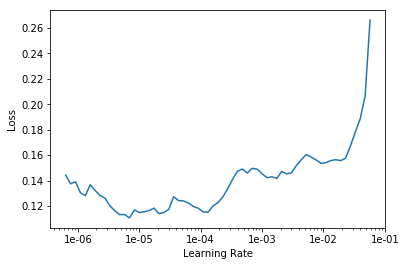

In [19]:
learn.recorder.plot()

In [20]:
learn.fit_one_cycle(5, max_lr=slice(1e-06, 1e-05))

epoch,train_loss,valid_loss,accuracy,time
0,0.153153,0.138697,0.952437,01:00
1,0.140121,0.140534,0.952437,01:01
2,0.140971,0.139896,0.949794,01:02
3,0.162971,0.137602,0.950675,01:01
4,0.128626,0.140430,0.953318,01:02


In [ ]:
learn.save('model_resnet50_places356_augment')

## Predict with TTA

In [ ]:
tta_pred = learn.TTA(ds_type=DatasetType.Test)

## Generate submission file

In [ ]:
image_name = pd.Series(os.listdir('train/test/'), name='image_name')
label = pd.Series(np.argmax(tta_pred[0], axis=1), name='label')
submission_df = pd.concat([image_name, label], axis=1)
submission_df.to_csv('submission_places365_tta.csv', index=False)